## **Comparing the performance of 13 Classifiers based on F1-score**<br/>
**Highlights:**
1. Correlation analysis using Pearson coefficient for continuous features and Cramer's V for categorical features
2. Data visualization using Seaborn FacetGrid plots
3. Results for each ML algorithm are presented after performing 5-fold cross validation based on F1-score

In [28]:
import os, random

import numpy as np
from scipy.stats import chi2_contingency
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras

## Set fixed ranom seeds to get reproducible results
seed_val = 0
os.environ['PYTHONHASHSEED'] = str(seed_val)
random.seed(seed_val)
np.random.seed(seed_val)
tf.random.set_seed(seed_val)

#### **1. Import and Clean Data**

In [36]:
df = pd.read_csv('./data/contoh.csv')
map = {"m" : 1, "f" : 0}
df["gender"] = df["gender"].map(map)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 624241 entries, 0 to 624240
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   name    624241 non-null  object
 1   gender  624241 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 9.5+ MB


In [37]:
df.sample(5)

,name,gender
47058,aji raja hakim,1
129766,chayra mikayla utomo,0
303189,lisnawati mustamin,0
67052,ana supriati,0
261776,iwang,1


##### **1.1. Missing values**

In [38]:
df.isnull().sum()

name      0
gender    0
dtype: int64

The dataset has no missing values.

##### **1.2. Type casting from `object` to `Categorical` and deleting features**

Finding categorical features and converting their pandas dtype to `categorical` will ease visualization

In [39]:
def summarize_categoricals(df, show_levels=False):
    """
        Display uniqueness in each column
    """
    data = [[df[c].unique(), len(df[c].unique()), df[c].isnull().sum()] for c in df.columns]
    df_temp = pd.DataFrame(data, index=df.columns,
                           columns=['Levels', 'No. of Levels',
                                    'No. of Missing Values'])
    return df_temp.iloc[:, 0 if show_levels else 1:]


def return_categoricals(df, threshold=5):
    """
        Returns a list of columns that have less than or equal to
        `threshold` number of unique categorical levels
    """
    return list(filter(lambda c: c if len(df[c].unique()) <= threshold else None,
                       df.columns))


def to_categorical(columns, df):
    """
        Converts the columns passed in `columns` to categorical datatype
    """
    for col in columns:
        df[col] = df[col].astype('category')
    return df

In [40]:
summarize_categoricals(df, show_levels=True)

,Levels,No. of Levels,No. of Missing Values
name,"[a'adila yasmin humairah, a'aliyah ananda rusd...",621535,0
gender,"[0, 1]",2,0


In [41]:
to_cast = return_categoricals(df, threshold=5)
df = to_categorical(to_cast, df)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 624241 entries, 0 to 624240
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype   
---  ------  --------------   -----   
 0   name    624241 non-null  object  
 1   gender  624241 non-null  category
dtypes: category(1), object(1)
memory usage: 5.4+ MB


In [43]:
df['name']

0               a'adila yasmin humairah
1                 a'aliyah ananda rusdi
2                                  a'am
3                         a'an darmawan
4             a'an dwi handika ramadhan
                      ...              
624236                  zysheila rizqia
624237                     zyva izabell
624238             zyva zhafira mandanu
624239    zyvanya dayang putri az-zahra
624240                zyvha eleora finn
Name: name, Length: 624241, dtype: object

#### **2. Correlations in the Data**

In [44]:
df.describe().T

,count,unique,top,freq
name,624241,621535,fitri jaya,3
gender,624241,2,1,322538


##### **2.1. Correlation between Quantitative variables**

In [ ]:
# fig, ax = plt.subplots(figsize=(10, 8))
# sns.heatmap(data=df.astype({'gender': 'int64'}).corr(),
#             annot=True, cmap='coolwarm', cbar_kws={'aspect': 50},
#             square=True, ax=ax)
# plt.xticks(rotation=30, ha='right');
# plt.tight_layout()

##### **2.2. Correlation between Qualitative/ Categorical variables**

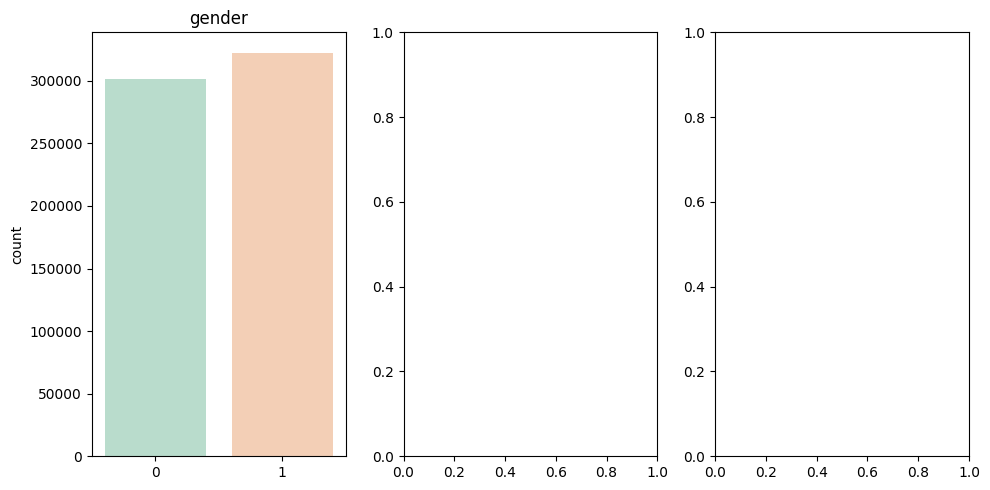

In [50]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
titles = list(df.select_dtypes(include='category'))

ax_title_pairs = zip(axs.flat, titles)

for ax, title in ax_title_pairs:
    sns.countplot(x=title, data=df, palette='Pastel2', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('')

plt.tight_layout()

#### **3. Data Visualization**

##### **3.1. Frequency distribution: Categorical Variables**

In [ ]:
df_grouped = df.groupby(by='gender')
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 8))
titles = list(df.select_dtypes(exclude='category'))

ax_title_pairs = zip(axs.flat, titles)

for ax, title in ax_title_pairs:
    sns.distplot(df_grouped.get_group(0)[title], bins=10, ax=ax, label='No')
    sns.distplot(df_grouped.get_group(1)[title], bins=10, ax=ax, label='Yes')
    ax.legend(title='DEATH_EVENT')

axs.flat[-1].remove()
axs.flat[-2].remove()
fig.tight_layout()

##### **3.2. Frequency distribution: Continuous Variables**

##### **3.3. Box plots : Outlier detection**

##### **3.4. Heart failure among gender based on smoking and BP**

##### **3.5. Heart failure among gender based on anaemia and diabetes**

#### **4. Data Preprocessing**<br/>
Data needs to be one-hot-encoded before applying machine learning models.

In [56]:
x = df.iloc[:, :-1]
y = df['gender']

categorical_columns = list(x.select_dtypes(include='category').columns)
numeric_columns = list(x.select_dtypes(exclude='category').columns)

##### **4.1. Train-Test split**<br/>
CatBoost classifier does not require any knd of preprocessing while Naive bayes requires a different kind of preprocesing. Therefore, we will use raw/unmodified data (`x_train_cat`, `x_test_cat`, `y_train_cat`, `y_test_cat`) for CatBoost and preprocessed data (`x_train`, `x_test`, `y_train`, `y_test`) for all other classifiers. For Naive Bayes, we will use the raw data (`x_train_cat`, `x_test_cat`, `y_train_cat`, `y_test_cat`) and preprocess it as required in the Naive Bayes section.

In [61]:
from sklearn.model_selection import train_test_split

data_splits = train_test_split(x, y, test_size=0.25, random_state=seed_val, shuffle=True, stratify=y)
x_train, x_test, y_train, y_test = data_splits


# For CatBoost and Naive Bayes
data_splits = train_test_split(x, y, test_size=0.25, random_state=seed_val, shuffle=True, stratify=y)
x_train_cat, x_test_cat, y_train_cat, y_test_cat = data_splits


# list(map(lambda x: x.shape, [x, y, x_train, x_test, y_train, y_test]))

In [62]:
pd.Series(y_test).value_counts()

gender
1    80635
0    75426
Name: count, dtype: int64

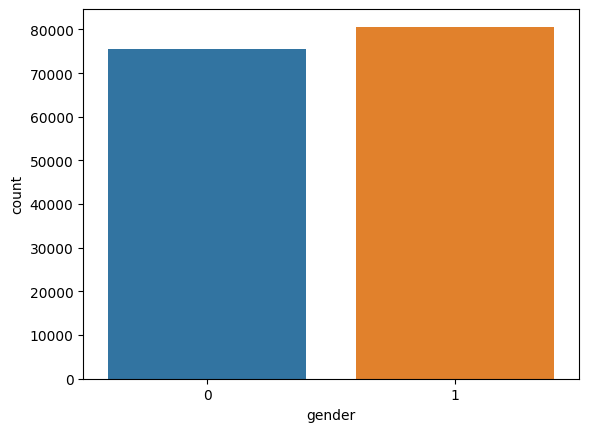

In [63]:
sns.countplot(x=y_test);

##### **4.2. Preprocessing Pipeline: One-hot Encoding, Standardization**<br/>
We need to standardize the continuous or quantitative variables/ features before applying Machine Learning models. This is important because if we don't standardize the features, features with high variance that are orders of magnitude larger that others might dominate the model fitting process and causing the model unable to learn from other features (with lower variance) correctly as expected.
There is no need to standardize categorical variables.

To know which algorithms require standardization/ feature scaling read this useful (stackoverflow post)[https://stats.stackexchange.com/questions/244507/what-algorithms-need-feature-scaling-beside-from-svm].

*Also we need to standardize the data only after performing train-test split because if we standardize before splitting then there is a chance for some information leak from the test set into the train set. We always want the test set to be completely new to the ML models. (Read more)[https://scikit-learn.org/stable/modules/compose.html#columntransformer-for-heterogeneous-data]*

In [78]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline 


numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', dtype=np.int))])

## Column Transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns)],
    remainder='passthrough')


## Applying Column Transformer
x_train = preprocessor.fit_transform(x_train)
x_test = preprocessor.transform(x_test)


## Label encoding
y_trans = LabelEncoder()
y_train = y_trans.fit_transform(y_train)
y_test = y_trans.transform(y_test)


## Save feature names after one-hot encoding for feature importances plots
feature_names = list(preprocessor.named_transformers_['cat'].named_steps['onehot'] \
                            .get_feature_names(input_features=categorical_columns))
feature_names = numeric_columns + feature_names

/var/folders/_w/v4htfwfd40ggzfmlgw22dk2m0000gn/T/ipykernel_14647/4084208379.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ('onehot', OneHotEncoder(drop='first', dtype=np.int))])


ValueError: could not convert string to float: 'bennediktus liing'

#### **5. Data Modeling**<br/>
Since the dataset is imbalanced we will be using class-weighted/ cost-sensitive learning. In cost-sensitive learning, a weighted cost function is used. Therefore, misclassifying a sample from the minority class will cost the classifiers more than misclassifying a sample from the majority class. In most of the Sklearn classifiers, cost-sensitive learning can be enabled by setting `class_weight='balanced'`.

##### **5.1. Utility Functions**

In [65]:
import timeit
import pickle
import sys
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, \
                            precision_recall_curve, roc_curve, accuracy_score
from sklearn.exceptions import NotFittedError

In [66]:
def confusion_plot(matrix, labels=None):
    """ Display binary confusion matrix as a Seaborn heatmap """
    
    labels = labels if labels else ['Negative (0)', 'Positive (1)']
    
    fig, ax = plt.subplots(nrows=1, ncols=1)
    sns.heatmap(data=matrix, cmap='Blues', annot=True, fmt='d',
                xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_xlabel('PREDICTED')
    ax.set_ylabel('ACTUAL')
    ax.set_title('Confusion Matrix')
    plt.close()
    
    return fig

In [68]:
def roc_plot(y_true, y_probs, label, compare=False, ax=None):
    """ Plot Receiver Operating Characteristic (ROC) curve 
        Set `compare=True` to use this function to compare classifiers. """
    
    fpr, tpr, thresh = roc_curve(y_true, y_probs, drop_intermediate=False)
    auc = round(roc_auc_score(y_true, y_probs), 2)
    
    fig, axis = (None, ax) if ax else plt.subplots(nrows=1, ncols=1)
    label = ' '.join([label, f'({auc})']) if compare else None
    sns.lineplot(x=fpr, y=tpr, ax=axis,
                 estimator=None, label=label)
    
    if compare:
        axis.legend(title='Classifier (AUC)', loc='lower right')
    else:
        axis.text(0.72, 0.05, f'AUC = { auc }', fontsize=12,
                  bbox=dict(facecolor='green', alpha=0.4, pad=5))
            
        # Plot No-Info classifier
        axis.fill_between(fpr, fpr, tpr, alpha=0.3, edgecolor='g',
                          linestyle='--', linewidth=2)
        
    axis.set_xlim(0, 1)
    axis.set_ylim(0, 1)
    axis.set_title('ROC Curve')
    axis.set_xlabel('False Positive Rate [FPR]\n(1 - Specificity)')
    axis.set_ylabel('True Positive Rate [TPR]\n(Sensitivity or Recall)')
    
    plt.close()
    
    return axis if ax else fig

In [69]:
def precision_recall_plot(y_true, y_probs, label, compare=False, ax=None):
    """ Plot Precision-Recall curve.
        Set `compare=True` to use this function to compare classifiers. """
    
    p, r, thresh = precision_recall_curve(y_true, y_probs)
    p, r, thresh = list(p), list(r), list(thresh)
    p.pop()
    r.pop()
    
    fig, axis = (None, ax) if ax else plt.subplots(nrows=1, ncols=1)
    
    if compare:
        sns.lineplot(r, p, estimator=None,
                     ax=axis, label=label)
        axis.set_xlabel('Recall')
        axis.set_ylabel('Precision')
        axis.legend(loc='lower left')
    else:
        sns.lineplot(thresh, p, estimator=None,
                     label='Precision', ax=axis)
        axis.set_xlabel('Threshold')
        axis.set_ylabel('Precision')
        axis.legend(loc='lower left')

        axis_twin = axis.twinx()
        sns.lineplot(thresh, r, estimator=None,
                     color='limegreen', label='Recall', ax=axis_twin)
        axis_twin.set_ylabel('Recall')
        axis_twin.set_ylim(0, 1)
        axis_twin.legend(bbox_to_anchor=(0.24, 0.18))
    
    axis.set_xlim(0, 1)
    axis.set_ylim(0, 1)
    axis.set_title('Precision Vs Recall')
    
    plt.close()
    
    return axis if ax else fig

In [70]:
def feature_importance_plot(importances, feature_labels, ax=None):
    fig, axis = (None, ax) if ax else plt.subplots(nrows=1, ncols=1, figsize=(5, 10))
    sns.barplot(x=importances, y=feature_labels, ax=axis)
    axis.set_title('Feature Importance Measures')
    
    plt.close()
    
    return axis if ax else fig

In [71]:
def train_clf(clf, x_train, y_train, sample_weight=None, refit=False):
    train_time = 0
    
    try:
        if refit:
            raise NotFittedError
        y_pred_train = clf.predict(x_train)
        
        # For neural nets
        y_pred_train = np.where(y_pred_train.flatten() > 0.5, 1, 0)
        
    except NotFittedError:
        start = timeit.default_timer()
        
        if sample_weight is not None:
            clf.fit(x_train, y_train, sample_weight=sample_weight)
        else:
            clf.fit(x_train, y_train)
        
        end = timeit.default_timer()
        train_time = end - start
        
        y_pred_train = clf.predict(x_train)
    
    train_acc = accuracy_score(y_train, y_pred_train)
    return clf, y_pred_train, train_acc, train_time

In [72]:
def model_memory_size(clf):
    return sys.getsizeof(pickle.dumps(clf))

In [73]:
def report(clf, x_train, y_train, x_test, y_test, display_scores=[],
           sample_weight=None, refit=False, importance_plot=False,
           confusion_labels=None, feature_labels=None, neural_net=False,
           verbose=True):
    """ Trains the passed classifier if not already trained and reports
        various metrics of the trained classifier """
    
    dump = dict()
    
    ## Train if not already trained
    clf, train_predictions, \
    train_acc, train_time = train_clf(clf, x_train, y_train,
                                      sample_weight=sample_weight,
                                      refit=refit)
    ## Testing
    start = timeit.default_timer()
    test_predictions = clf.predict(x_test)
    end = timeit.default_timer()
    test_time = end - start
    
    # For neural nets
    if neural_net:
        y_probs = np.copy(test_predictions)
        test_predictions = np.where(test_predictions.flatten() > 0.5, 1, 0)
    else:
        y_probs = clf.predict_proba(x_test)[:, 1]
    
    test_acc = accuracy_score(y_test, test_predictions)
    roc_auc = roc_auc_score(y_test, y_probs)
        
    ## Additional scores
    scores_dict = dict()
    for func in display_scores:
        scores_dict[func.__name__] = [func(y_train, train_predictions),
                                      func(y_test, test_predictions)]
        
    ## Model Memory
    model_mem = None
    if not neural_net:
        model_mem = round(model_memory_size(clf) / 1024, 2)
    
    print(clf)
    print("\n=============================> TRAIN-TEST DETAILS <======================================")
    
    ## Metrics
    print(f"Train Size: {x_train.shape[0]} samples")
    print(f" Test Size: {x_test.shape[0]} samples")
    print("---------------------------------------------")
    print(f"Training Time: {round(train_time, 3)} seconds")
    print(f" Testing Time: {round(test_time, 3)} seconds")
    print("---------------------------------------------")
    print("Train Accuracy: ", train_acc)
    print(" Test Accuracy: ", test_acc)
    print("---------------------------------------------")
    
    if display_scores:
        for k, v in scores_dict.items():
            score_name = ' '.join(map(lambda x: x.title(), k.split('_')))
            print(f'Train {score_name}: ', v[0])
            print(f' Test {score_name}: ', v[1])
            print()
        print("---------------------------------------------")
    
    print(" Area Under ROC (test): ", roc_auc)
    print("---------------------------------------------")
    print(f"Model Memory Size: {model_mem} kB")
    print("\n=============================> CLASSIFICATION REPORT <===================================")
    
    ## Classification Report
    clf_rep = classification_report(y_test, test_predictions, output_dict=True)
    
    print(classification_report(y_test, test_predictions,
                                target_names=confusion_labels))
    
    
    if verbose:
        print("\n================================> CONFUSION MATRIX <=====================================")
    
        ## Confusion Matrix HeatMap
        display(confusion_plot(confusion_matrix(y_test, test_predictions),
                               labels=confusion_labels))
        print("\n=======================================> PLOTS <=========================================")


        ## Variable importance plot
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
        roc_axes = axes[0, 0]
        pr_axes = axes[0, 1]
        importances = None

        if importance_plot:
            if not feature_labels:
                raise RuntimeError("'feature_labels' argument not passed "
                                   "when 'importance_plot' is True")

            try:
                importances = pd.Series(clf.feature_importances_,
                                        index=feature_labels) \
                                .sort_values(ascending=False)
            except AttributeError:
                try:
                    importances = pd.Series(clf.coef_.ravel(),
                                            index=feature_labels) \
                                    .sort_values(ascending=False)
                except AttributeError:
                    pass

            if importances is not None:
                # Modifying grid
                grid_spec = axes[0, 0].get_gridspec()
                for ax in axes[:, 0]:
                    ax.remove()   # remove first column axes
                large_axs = fig.add_subplot(grid_spec[0:, 0])

                # Plot importance curve
                feature_importance_plot(importances=importances.values,
                                        feature_labels=importances.index,
                                        ax=large_axs)
                large_axs.axvline(x=0)

                # Axis for ROC and PR curve
                roc_axes = axes[0, 1]
                pr_axes = axes[1, 1]
            else:
                # remove second row axes
                for ax in axes[1, :]:
                    ax.remove()
        else:
            # remove second row axes
            for ax in axes[1, :]:
                ax.remove()


        ## ROC and Precision-Recall curves
        clf_name = clf.__class__.__name__
        roc_plot(y_test, y_probs, clf_name, ax=roc_axes)
        precision_recall_plot(y_test, y_probs, clf_name, ax=pr_axes)

        fig.subplots_adjust(wspace=5)
        fig.tight_layout()
        display(fig)
    
    ## Dump to report_dict
    dump = dict(clf=clf, accuracy=[train_acc, test_acc], **scores_dict,
                train_time=train_time, train_predictions=train_predictions,
                test_time=test_time, test_predictions=test_predictions,
                test_probs=y_probs, report=clf_rep, roc_auc=roc_auc,
                model_memory=model_mem)
    
    return clf, dump

In [74]:
def compare_models(y_test=None, clf_reports=[], labels=[], score='accuracy'):
    """ Compare evaluation metrics for the True Positive class [1] of 
        binary classifiers passed in the argument and plot ROC and PR curves.
        
        Arguments:
        ---------
        y_test: to plot ROC and Precision-Recall curves
         score: is the name corresponding to the sklearn metrics
        
        Returns:
        -------
        compare_table: pandas DataFrame containing evaluated metrics
                  fig: `matplotlib` figure object with ROC and PR curves """

    
    ## Classifier Labels
    default_names = [rep['clf'].__class__.__name__ for rep in clf_reports]
    clf_names =  labels if len(labels) == len(clf_reports) else default_names
    
    
    ## Compare Table
    table = dict()
    index = ['Train ' + score, 'Test ' + score, 'Overfitting', 'Accuracy', 'ROC Area',
             'Precision', 'Recall', 'F1-score', 'Support']
    for i in range(len(clf_reports)):
        scores = [round(i, 3) for i in clf_reports[i][score]]
        
        roc_auc = clf_reports[i]['roc_auc']
        test_acc = clf_reports[i]['accuracy'][1]
        
        # Get metrics of True Positive class from sklearn classification_report
        true_positive_metrics = list(clf_reports[i]['report']["1"].values())
        
        table[clf_names[i]] = scores + [scores[1] < scores[0], test_acc, roc_auc] + \
                              true_positive_metrics
    
    table = pd.DataFrame(data=table, index=index)
    
    
    ## Compare Plots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    
    # ROC and Precision-Recall
    for i in range(len(clf_reports)):
        clf_probs = clf_reports[i]['test_probs']
        roc_plot(y_test, clf_probs, label=clf_names[i],
                 compare=True, ax=axes[0])
        precision_recall_plot(y_test, clf_probs, label=clf_names[i],
                              compare=True, ax=axes[1])
    # Plot No-Info classifier
    axes[0].plot([0,1], [0,1], linestyle='--', color='green')
        
    fig.tight_layout()
    plt.close()
    
    return table.T, fig

##### **5.2. Naive Bayes**<br/>
The fundamental assumption made by Naive Bayes regarding the data is **class conditional independence of features**. Sklearn provides different variants of Naive Bayes depending on whether the features follow a categorical distribution (CategoricalNB), normal distribution (GaussianNB), bernoulli distribution (BernoulliNB), multinomial distribution (MultinomialNB).

Since majority of the features are categorical and follow a categorical distribution, we will use CategoricalNB. Continuous features will be discretized.

In [75]:
from sklearn import metrics
primary_eval_metric = metrics.f1_score

confusion_lbs = ['Perempuan', 'Laki-Laki']

In [ ]:
from sklearn.naive_bayes import CategoricalNB, GaussianNB 
from sklearn.preprocessing import KBinsDiscretizer, OrdinalEncoder


numeric_trans_nb = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('kbn', KBinsDiscretizer(n_bins=5, encode='ordinal'))])

categorical_trans_nb = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(dtype=np.int64))])

## Column Transformer
preprocessor_nb = ColumnTransformer(
    transformers=[
        ('num', numeric_trans_nb, numeric_columns),
        ('cat', categorical_trans_nb, categorical_columns)],
    remainder='passthrough')


## Applying Column Transformer
x_train_nb = preprocessor_nb.fit_transform(x_train_cat)
x_test_nb = preprocessor_nb.transform(x_test_cat)

nb_clf = CategoricalNB()

nb_clf, nb_report = report(nb_clf, x_train_nb, y_train,
                           x_test_nb, y_test,
                           display_scores=[primary_eval_metric],
                           refit=True,
                           confusion_labels=confusion_lbs)

##### **5.3. Logistic Regression**

In [77]:
from sklearn.linear_model import LogisticRegressionCV

logit_cv = LogisticRegressionCV(class_weight='balanced', cv=5,
                                max_iter=500, penalty='l1',
                                scoring='f1', solver='liblinear',
                                n_jobs=-1, random_state=seed_val,
                                refit=True, verbose=0)

logit_cv, logit_report = report(logit_cv, x_train, y_train,
                                x_test, y_test,
                                display_scores=[primary_eval_metric],
                                importance_plot=True,
                                feature_labels=feature_names,
                                confusion_labels=confusion_lbs)

NameError: name 'feature_names' is not defined

##### **5.4. K-Nearest Neighbors**<br/>
KNN estimator in Scikit-learn does not provide a way to pass class-weights to enable cost-sensitive/ class-weighted learning.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5, p=3,
                           weights='distance', n_jobs=-1)

knn, knn_report = report(knn, x_train, y_train,
                         x_test, y_test,
                         display_scores=[primary_eval_metric],
                         importance_plot=True,
                         feature_labels=feature_names,
                         confusion_labels=confusion_lbs)

##### **5.5. Decision Tree**

In [ ]:
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier(class_weight='balanced',
                                       criterion='entropy',
                                       max_depth=6, max_leaf_nodes=10,
                                       min_samples_split=0.2,
                                       random_state=seed_val)

decision_tree, decision_tree_report = report(decision_tree, x_train, y_train,
                                             x_test, y_test,
                                             display_scores=[primary_eval_metric],
                                             importance_plot=True,
                                             feature_labels=feature_names,
                                             confusion_labels=confusion_lbs)

##### **5.6. Decision Trees with Bagging**

In [ ]:
from sklearn.ensemble import BaggingClassifier

bagging_dtree = DecisionTreeClassifier(max_depth=2, class_weight='balanced',
                                       criterion='entropy', random_state=seed_val)

bagging_clf = BaggingClassifier(base_estimator=bagging_dtree,
                                max_samples=0.745, n_estimators=100,
                                max_features=0.37,
                                n_jobs=-1, random_state=seed_val)

bagging_clf, bagging_clf_report = report(bagging_clf, x_train, y_train,
                                         x_test, y_test,
                                         display_scores=[primary_eval_metric],
                                         feature_labels=feature_names,
                                         confusion_labels=confusion_lbs)

##### **5.7. Random Forests**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(class_weight='balanced', criterion='entropy',
                                       max_depth=2, max_samples=0.63, n_estimators=100,
                                       n_jobs=-1, random_state=seed_val)

random_forest, random_forest_report = report(random_forest, x_train, y_train,
                                             x_test, y_test,
                                             display_scores=[primary_eval_metric],
                                             importance_plot=True,
                                             feature_labels=feature_names,
                                             confusion_labels=confusion_lbs)

##### **5.8. Decision Trees with AdaBoost**<br/>
The default base estimator for `AdaBoostClassifier` is `DecisionTreeClassifier(max_depth=1)`

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

adaboot = AdaBoostClassifier(n_estimators=57, learning_rate=0.064,
                             random_state=seed_val)

adaboot, adaboot_report = report(adaboot, x_train, y_train,
                                 x_test, y_test,
                                 display_scores=[primary_eval_metric],
                                 importance_plot=True,
                                 feature_labels=feature_names,
                                 confusion_labels=confusion_lbs)

##### **5.9. Linear SVC**

In [ ]:
from sklearn.svm import SVC

linear_svc = SVC(C=2.1, kernel='linear', probability=True,
                 class_weight='balanced', random_state=seed_val)

linear_svc, linear_svc_report = report(linear_svc, x_train, y_train,
                                       x_test, y_test,
                                       display_scores=[primary_eval_metric],
                                       importance_plot=True,
                                       feature_labels=feature_names,
                                       confusion_labels=confusion_lbs)

##### **5.10. SVM with RBF kernel**

In [ ]:
rbf_svc = SVC(C=0.25, kernel='rbf', probability=True,
              class_weight='balanced', random_state=seed_val)

rbf_svc, rbf_svc_report = report(rbf_svc, x_train, y_train,
                                 x_test, y_test,
                                 display_scores=[primary_eval_metric],
                                 importance_plot=True,
                                 feature_labels=feature_names,
                                 confusion_labels=confusion_lbs)

##### **5.11. XGBoost**

In [ ]:
from xgboost import XGBClassifier
from sklearn.utils import class_weight

cls_weight = (y_train.shape[0] - np.sum(y_train)) / np.sum(y_train)

params = {'learning_rate': 0.014724527414939945,
          'num_boost_round': 3451,
          'gamma': 0.4074467665676125,
          'reg_lambda': 31.082862686792716,
          'reg_alpha': 0.008543705214252668,
          'max_depth': 7,
          'min_child_weight': 3.2435633342899867e-06,
          'subsample': 0.15432895096353877,
          'colsample_bytree': 0.7665394913603492}

xgb_clf = XGBClassifier(**params, scale_pos_weight=cls_weight,
                        random_state=seed_val, n_jobs=-1)
xgb_clf.fit(x_train, y_train);

xgb_clf, xgb_report = report(xgb_clf, x_train, y_train,
                             x_test, y_test,
                             display_scores=[primary_eval_metric],
                             importance_plot=True,
                             feature_labels=feature_names,
                             confusion_labels=confusion_lbs)

##### **5.12. LightGBM**<br/>
LightGBM is similar to XGBoost but grows the trees in the ensemble based on Leaf-wise growth algorithm unlike Level-wise algorithm in XGBoost.

In [ ]:
from lightgbm import LGBMClassifier

params = {'objective': 'binary', 'verbose': -1, 'lambda_l1': 0.0,
          'lambda_l2': 0.0, 'num_leaves': 31, 'feature_fraction': 0.8,
          'bagging_fraction': 0.49916588402130324, 'bagging_freq': 3,
          'min_child_samples': 20}

lgbm_clf = LGBMClassifier(**params, random_state=seed_val, n_jobs=-1)
lgbm_clf.fit(x_train, y_train);

lgbm_clf, lgbm_report = report(lgbm_clf, x_train, y_train,
                               x_test, y_test,
                               display_scores=[primary_eval_metric],
                               importance_plot=True,
                               feature_labels=feature_names,
                               confusion_labels=confusion_lbs)

##### **5.13. CatBoost**<br/>
Cat boost performs better without One-hot encoding because it performs an internal categorical encoding that is similar to Leave One Out Encoding (LOOE). So, we can give the dataframe as input to the catboost classifier.

In [ ]:
from catboost import CatBoostClassifier

catboost_clf = CatBoostClassifier(cat_features=categorical_columns,
                                  l2_leaf_reg=120, depth=6,
                                  auto_class_weights='Balanced',
                                  iterations=200, learning_rate=0.16,
                                  use_best_model=True,
                                  early_stopping_rounds=150,
                                  eval_metric='F1', random_state=seed_val)

catboost_clf.fit(x_train_cat, y_train, 
                 eval_set=(x_train_cat, y_train),
                 verbose=False)


f_labels = categorical_columns+numeric_columns
catboost_clf, catboost_report = report(catboost_clf, x_train_cat, y_train,
                                       x_test_cat, y_test,
                                       display_scores=[primary_eval_metric],
                                       importance_plot=True,
                                       feature_labels=f_labels,
                                       confusion_labels=confusion_lbs)

##### **5.14. Artificial Neural Networks**

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

CLASS_WEIGHT = compute_class_weight(class_weight='balanced',
                                    classes=np.unique(y_train),
                                    y=y_train)
CLASS_WEIGHT = dict(zip([0, 1], CLASS_WEIGHT))

BATCHSIZE = x_train.shape[0]
FEATURES = x_train.shape[1]
CLASSES = 1
EPOCHS = 1000
N_TRAIN_EXAMPLES = x_train.shape[0]
STEPS_PER_EPOCH = N_TRAIN_EXAMPLES // BATCHSIZE

In [ ]:
def create_model(params, num_classes, metrics):    
    layers_list = [keras.layers.InputLayer(input_shape=(FEATURES,))]
    
    for l in range(1, params['num_layers'] + 1):
        new_layers = [keras.layers.BatchNormalization(),
                      keras.layers.Dense(params[f'units_{l}'], activation='relu',
                                         kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_val),
                                         kernel_regularizer=keras.regularizers.l2(0.001),
                                         use_bias=True),
                      keras.layers.Dropout(params[f'drop_rate_{l}'], seed=seed_val)]
        layers_list.extend(new_layers)
    
    layers_list.append(keras.layers.Dense(num_classes, activation='sigmoid'))
    model = keras.Sequential(layers=layers_list)
    
    model.compile(optimizer='adam',
                  loss="binary_crossentropy",
                  metrics=metrics)

    return model

In [ ]:
tf.keras.backend.clear_session()

params_dict = {'drop_rate_1': 0.7, 'num_layers': 1, 'units_1': 8}

## tf.keras.metrics does not have F1-score so we will use Recall
model = create_model(params=params_dict, num_classes=CLASSES,
                     metrics=[keras.metrics.Recall()])

model.summary()

In [ ]:
callbacks = [tf.keras.callbacks.EarlyStopping(patience=5, verbose=0)]

history = model.fit(x=x_train, y=y_train,
                    batch_size=BATCHSIZE,
                    epochs=EPOCHS,
                    verbose=0,
                    callbacks=callbacks,
                    validation_data=(x_test, y_test),
                    shuffle=True,
                    class_weight=CLASS_WEIGHT,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    use_multiprocessing=True)

_, nn_report = report(model, x_train, y_train,
                      x_test, y_test,
                      display_scores=[primary_eval_metric],
                      confusion_labels=confusion_lbs,
                      neural_net=True)

#### **6. Model Comparison**

In [ ]:
report_list = [nb_report, logit_report, knn_report, decision_tree_report,               
               bagging_clf_report, random_forest_report, adaboot_report,
               xgb_report, lgbm_report, catboost_report, nn_report,
               linear_svc_report, rbf_svc_report]
clf_labels = [rep['clf'].__class__.__name__ for rep in report_list]
clf_labels[-3] = 'Neural Nets'
clf_labels[-2] = 'Linear SVC'
clf_labels[-1] = 'RBF SVC'

##### **6.1. Evaluation Metrics**

In [ ]:
compare_table, compare_plot = compare_models(y_test, clf_reports=report_list,
                                             labels=clf_labels,
                                             score=primary_eval_metric.__name__)

compare_table.sort_values(by=['Overfitting', 'F1-score'], ascending=[True, False])

##### **6.2. ROC and PR Curves**

In [ ]:
compare_plot